In [35]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder.appName('CustomerSegmentation').getOrCreate()
df = spark.read.csv('/content/sample_data/BankChurners.csv',
                    header=True, inferSchema=True)
df.show(3)

+---------+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+----------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------+
|CLIENTNUM|   Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|Naive_Bayes_Classifier_Attrit

In [36]:
df = df.drop("Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1",
             "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2")

In [37]:
df = df.withColumn("churn", F.when(F.col("Attrition_Flag") == "Attrited Customer", 1).otherwise(0))

In [38]:
#RFM Analysis

from pyspark.ml.feature import QuantileDiscretizer
for col_name, q in [("Months_on_book",5), ("Total_Trans_Ct",5), ("Total_Trans_Amt",5)]:
    qds = QuantileDiscretizer(numBuckets=q, inputCol=col_name, outputCol=col_name+"_q")
    df = qds.fit(df).transform(df)


In [39]:
from pyspark.sql.functions import when,col

df = df.withColumn("Months_on_book_band",
    when(col("Months_on_book_q") == 0, "Very Low")
    .when(col("Months_on_book_q") == 1, "Low")
    .when(col("Months_on_book_q") == 2, "Medium")
    .when(col("Months_on_book_q") == 3, "High")
    .otherwise("Very High")
)
df.show(3)

+---------+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+-----+----------------+----------------+-----------------+-------------------+
|CLIENTNUM|   Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|churn|Months_on_book_q|Total_Trans_Ct_q|Total_Trans_Amt_q|Months_on_book_band|
+---------+-----------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------

In [40]:
#Feature engineering and Scaling

from pyspark.ml.feature import VectorAssembler, StandardScaler

assembler = VectorAssembler(
    inputCols=["Months_on_book_q","Total_Trans_Ct_q","Total_Trans_Amt_q"],
    outputCol="features_raw")
df_fe = assembler.transform(df)

In [41]:
scaler = StandardScaler(inputCol="features_raw", outputCol="features", withMean=True, withStd=True)
df_fe = scaler.fit(df_fe).transform(df_fe)

In [42]:
# Clustering with K‑Means

In [43]:
from pyspark.ml.feature import PCA

pca = PCA(k=2, inputCol="features", outputCol="pca_features")
df_pca = pca.fit(df_fe).transform(df_fe)


In [44]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator(featuresCol='features', metricName='silhouette', distanceMeasure='squaredEuclidean')

silhouette_scores = []

for k in range(2, 11):  # Try k from 2 to 10
    kmeans = KMeans(featuresCol='features', k=k, seed=42)
    model = kmeans.fit(df_fe)
    predictions = model.transform(df_fe)

    score = evaluator.evaluate(predictions)
    silhouette_scores.append((k, score))
    print(f"Silhouette Score for k={k}: {score:.4f}")

Silhouette Score for k=2: 0.6021
Silhouette Score for k=3: 0.4442
Silhouette Score for k=4: 0.5908
Silhouette Score for k=5: 0.5684
Silhouette Score for k=6: 0.4944
Silhouette Score for k=7: 0.5253
Silhouette Score for k=8: 0.5515
Silhouette Score for k=9: 0.4808
Silhouette Score for k=10: 0.5071


In [45]:
best_k = max(silhouette_scores, key=lambda x: x[1])
print(f"Best k by silhouette score: {best_k[0]} with score {best_k[1]:.4f}")


Best k by silhouette score: 2 with score 0.6021


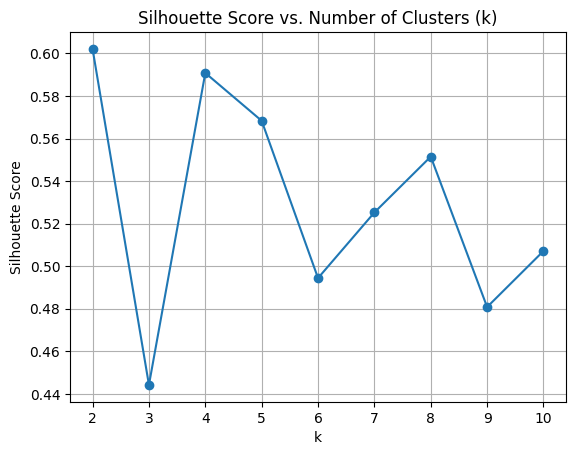

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

df_scores = pd.DataFrame(silhouette_scores, columns=["k", "silhouette"])
plt.plot(df_scores["k"], df_scores["silhouette"], marker='o')
plt.title("Silhouette Score vs. Number of Clusters (k)")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()


In [47]:
df_clust.select("cluster", "churn").show(5)

+-------+-----+
|cluster|churn|
+-------+-----+
|      0|    0|
|      0|    0|
|      0|    0|
|      1|    0|
|      1|    0|
+-------+-----+
only showing top 5 rows



In [48]:
# Count churned and active customers per cluster
churn_by_cluster = df_clust.groupBy("cluster", "churn").count().orderBy("cluster")
churn_by_cluster.show()

+-------+-----+-----+
|cluster|churn|count|
+-------+-----+-----+
|      0|    0| 1720|
|      0|    1|  866|
|      1|    0| 1181|
|      1|    1|  452|
|      2|    1|  115|
|      2|    0| 2054|
|      3|    1|  194|
|      3|    0| 3545|
+-------+-----+-----+



In [49]:
pdf = churn_by_cluster.toPandas()

# Pivot to get churn distribution per cluster
pivot_df = pdf.pivot(index='cluster', columns='churn', values='count').fillna(0)
pivot_df.columns = ['Active', 'Churned']
pivot_df['Total'] = pivot_df['Active'] + pivot_df['Churned']
pivot_df['ChurnRate'] = pivot_df['Churned'] / pivot_df['Total']
pivot_df.reset_index(inplace=True)
pivot_df

,cluster,Active,Churned,Total,ChurnRate
0,0,1720,866,2586,0.334880
1,1,1181,452,1633,0.276791
2,2,2054,115,2169,0.053020
3,3,3545,194,3739,0.051886


/tmp/ipython-input-50-2740230948.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="cluster", y="ChurnRate", data=pivot_df, palette="viridis")


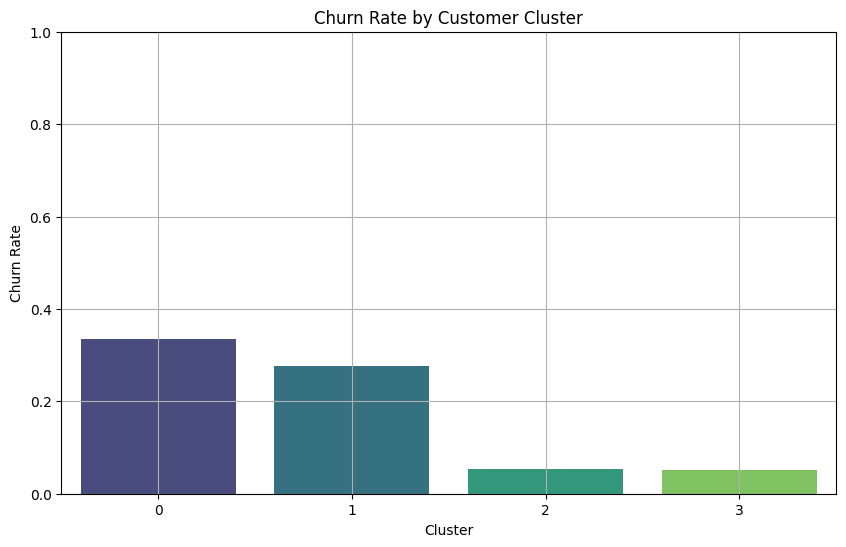

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x="cluster", y="ChurnRate", data=pivot_df, palette="viridis")
plt.title("Churn Rate by Customer Cluster")
plt.xlabel("Cluster")
plt.ylabel("Churn Rate")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [55]:
df_clust.groupBy("cluster").count().show()

+-------+-----+
|cluster|count|
+-------+-----+
|      1| 1633|
|      3| 3739|
|      2| 2169|
|      0| 2586|
+-------+-----+



In [56]:
from pyspark.sql.functions import avg
df_clust.groupBy("cluster").agg(avg("Total_Trans_Amt"), avg("Avg_Utilization_Ratio"), avg("Total_Trans_Ct")).show()

+-------+--------------------+--------------------------+-------------------+
|cluster|avg(Total_Trans_Amt)|avg(Avg_Utilization_Ratio)|avg(Total_Trans_Ct)|
+-------+--------------------+--------------------------+-------------------+
|      1|  2128.6068585425596|        0.2632363747703607|  44.70483772198408|
|      3|   6036.020058839262|       0.28571730409200335|  80.52179727199785|
|      2|    6197.22775472568|       0.28733886583679086|  81.33978792070079|
|      0|  1977.4559164733178|       0.25616666666666665|  41.11523588553751|
+-------+--------------------+--------------------------+-------------------+



In [57]:
#Churn Prediction with ML
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import OneHotEncoder, StringIndexer

In [58]:
# churn_label is already numeric
cluster_indexer = StringIndexer(inputCol="cluster", outputCol="cluster_idx")
cluster_encoded = OneHotEncoder(inputCols=["cluster_idx"], outputCols=["cluster_vec"])

assembler2 = VectorAssembler(inputCols=["cluster_vec", "Avg_Utilization_Ratio", "Customer_Age"], outputCol="final_features")
lr = LogisticRegression(featuresCol="final_features", labelCol="churn")

In [59]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[cluster_indexer, cluster_encoded, assembler2, lr])
model_full = pipeline.fit(df_clust)

In [60]:
#Model Evaluation
from pyspark.ml.evaluation import BinaryClassificationEvaluator
preds = model_full.transform(df_clust)
evaluator = BinaryClassificationEvaluator(labelCol="churn", rawPredictionCol="rawPrediction")
print("AUC:", evaluator.evaluate(preds))

preds.groupBy("churn", "prediction").count().show()

AUC: 0.8116073972305585
+-----+----------+-----+
|churn|prediction|count|
+-----+----------+-----+
|    1|       0.0| 1627|
|    0|       0.0| 8500|
+-----+----------+-----+



In [61]:
#Cluster-Wise Feature Statistics
from pyspark.sql.functions import avg, count

df_clust.groupBy("cluster").agg(
    count("*").alias("num_customers"),
    avg("churn").alias("churn_rate"),
    avg("Total_Trans_Amt").alias("avg_trans_amt"),
    avg("Total_Trans_Ct").alias("avg_trans_ct"),
    avg("Avg_Utilization_Ratio").alias("avg_util_ratio"),
    avg("Credit_Limit").alias("avg_credit"),
    avg("Customer_Age").alias("avg_age")
).orderBy("cluster").show()

+-------+-------------+--------------------+------------------+-----------------+-------------------+-----------------+------------------+
|cluster|num_customers|          churn_rate|     avg_trans_amt|     avg_trans_ct|     avg_util_ratio|       avg_credit|           avg_age|
+-------+-------------+--------------------+------------------+-----------------+-------------------+-----------------+------------------+
|      0|         2586|  0.3348801237432328|1977.4559164733178|41.11523588553751|0.25616666666666665|8521.357540603272| 50.54292343387471|
|      1|         1633|  0.2767911818738518|2128.6068585425596|44.70483772198408| 0.2632363747703607| 8553.52718922231| 39.24494794856093|
|      2|         2169| 0.05301982480405717|  6197.22775472568|81.33978792070079|0.28733886583679086| 8739.60908252652|41.235592438911944|
|      3|         3739|0.051885530890612465| 6036.020058839262|80.52179727199785|0.28571730409200335|8680.246723722952| 49.45493447445841|
+-------+-------------+----

In [62]:
#Churn rate by cluster
churn_counts = df_clust.groupBy("cluster", "churn").count().toPandas()

pivot = churn_counts.pivot(index='cluster', columns='churn', values='count').fillna(0)
pivot.columns = ['Active', 'Churned']
pivot['ChurnRate'] = pivot['Churned'] / (pivot['Churned'] + pivot['Active'])
pivot

,Active,Churned,ChurnRate
cluster,,,
0,1720,866,0.334880
1,1181,452,0.276791
2,2054,115,0.053020
3,3545,194,0.051886


In [63]:
# Feature Importance via Correlation
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=[
        "Customer_Age", "Months_on_book", "Total_Trans_Amt", "Total_Trans_Ct",
        "Avg_Utilization_Ratio", "Credit_Limit", "Contacts_Count_12_mon"
    ], outputCol="corr_features")

df_corr = assembler.transform(df_clust)

corr_matrix = Correlation.corr(df_corr, "corr_features", method="pearson").head()[0].toArray()
corr_matrix

array([[ 1.        ,  0.78891236, -0.04644649, -0.06709686,  0.00711422,
         0.00247623, -0.01845185],
       [ 0.78891236,  1.        , -0.03859063, -0.04981908, -0.00754084,
         0.00750701, -0.01077448],
       [-0.04644649, -0.03859063,  1.        ,  0.80719203, -0.08303425,
         0.17173015, -0.11277393],
       [-0.06709686, -0.04981908,  0.80719203,  1.        ,  0.00283811,
         0.07592691, -0.15221261],
       [ 0.00711422, -0.00754084, -0.08303425,  0.00283811,  1.        ,
        -0.48296507, -0.05547128],
       [ 0.00247623,  0.00750701,  0.17173015,  0.07592691, -0.48296507,
         1.        ,  0.02081701],
       [-0.01845185, -0.01077448, -0.11277393, -0.15221261, -0.05547128,
         0.02081701,  1.        ]])

In [64]:
import pandas as pd
numeric_cols = ["Customer_Age", "Months_on_book", "Total_Trans_Amt", "Total_Trans_Ct", "Avg_Utilization_Ratio", "Credit_Limit"]
pdf = df_clust.select(numeric_cols + ["churn"]).toPandas()
pdf.corr()["churn"].sort_values(ascending=False)

,churn
churn,1.000000
Customer_Age,0.018203
Months_on_book,0.013687
Credit_Limit,-0.023873
Total_Trans_Amt,-0.168598
Avg_Utilization_Ratio,-0.178410
Total_Trans_Ct,-0.371403


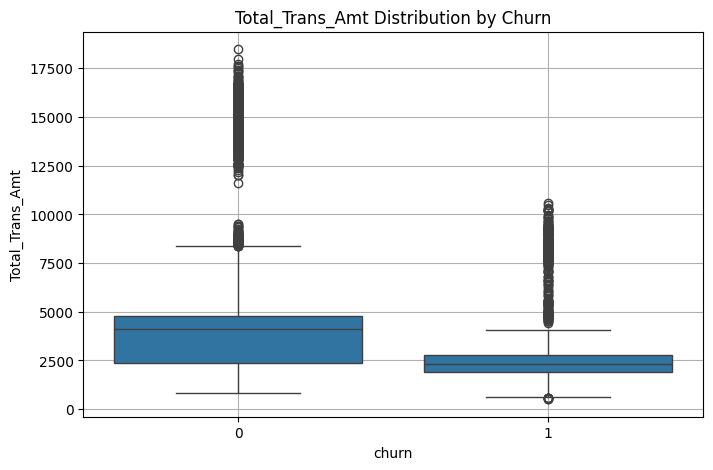

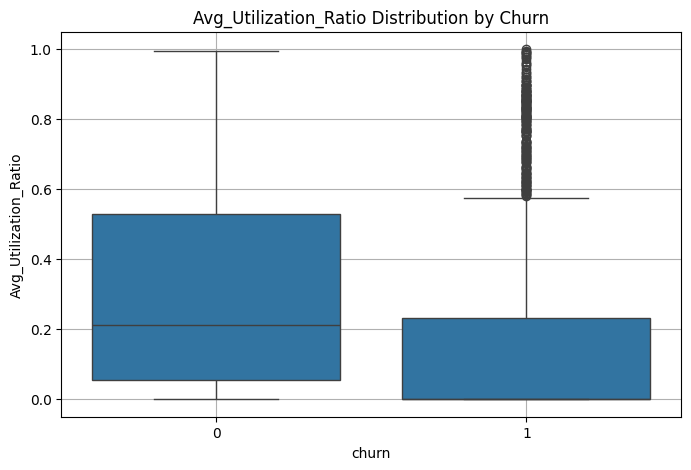

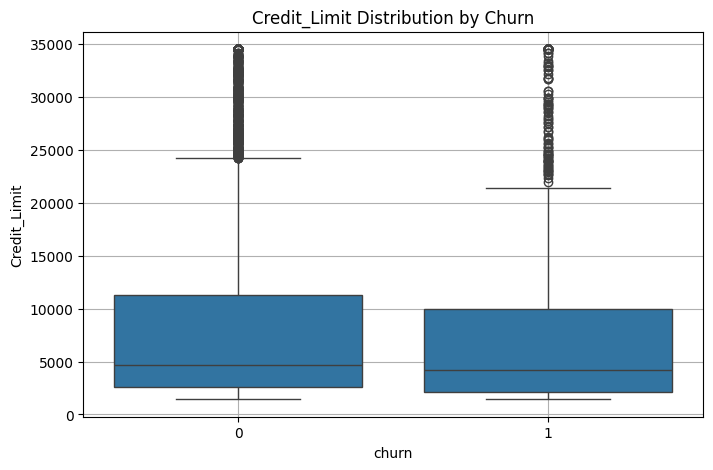

In [65]:
#Boxplots & Feature Distributions

import seaborn as sns
import matplotlib.pyplot as plt

for col in ["Total_Trans_Amt", "Avg_Utilization_Ratio", "Credit_Limit"]:
    plt.figure(figsize=(8,5))
    sns.boxplot(data=pdf, x="churn", y=col)
    plt.title(f"{col} Distribution by Churn")
    plt.grid(True)
    plt.show()

<Axes: xlabel='Total_Trans_Amt', ylabel='Density'>

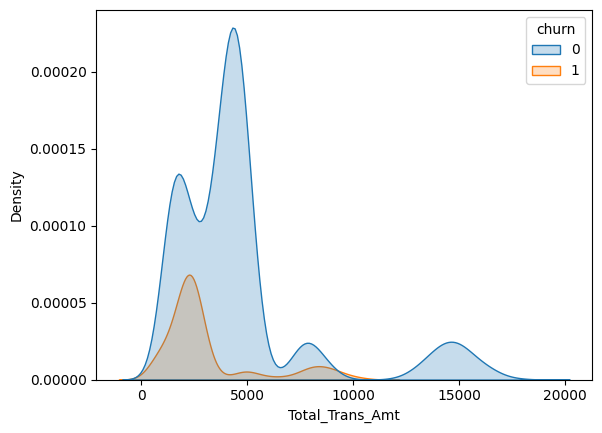

In [66]:
sns.kdeplot(data=pdf, x="Total_Trans_Amt", hue="churn", fill=True)

In [69]:
from pyspark.ml.feature import QuantileDiscretizer

rfm_cols = ["Months_on_book", "Total_Trans_Ct", "Total_Trans_Amt"]
for col_name in rfm_cols:
  discretizer = QuantileDiscretizer(numBuckets=5, inputCol=col_name, outputCol=f"{col_name}_q_new")
  df_clust = discretizer.fit(df_clust).transform(df_clust)

# Optionally create an RFM score (0-12)
from pyspark.sql.functions import col

df_clust = df_clust.withColumn("rfm_score",
    col("Months_on_book_q") + col("Total_Trans_Ct_q") + col("Total_Trans_Amt_q"))


In [70]:
df_clust.groupBy("rfm_score").count().orderBy("rfm_score").show()

+---------+-----+
|rfm_score|count|
+---------+-----+
|      0.0|  227|
|      1.0|  435|
|      2.0| 1081|
|      3.0| 1199|
|      4.0|  905|
|      5.0|  878|
|      6.0| 1040|
|      7.0| 1170|
|      8.0| 1194|
|      9.0|  944|
|     10.0|  811|
|     11.0|  243|
+---------+-----+



In [71]:
from pyspark.sql.functions import when, col

df_clust = df_clust.withColumn("rfm_tier",
    when(col("rfm_score") >= 10, "Platinum")
    .when(col("rfm_score") >= 7, "Gold")
    .when(col("rfm_score") >= 4, "Silver")
    .otherwise("Bronze")
)

In [72]:
df_clust.groupBy("rfm_tier").count().orderBy("rfm_tier").show()

+--------+-----+
|rfm_tier|count|
+--------+-----+
|  Bronze| 2942|
|    Gold| 3308|
|Platinum| 1054|
|  Silver| 2823|
+--------+-----+



In [73]:
df_clust.select("CLIENTNUM", "rfm_score", "rfm_tier").show(10, truncate=False)

+---------+---------+--------+
|CLIENTNUM|rfm_score|rfm_tier|
+---------+---------+--------+
|768805383|3.0      |Bronze  |
|818770008|3.0      |Bronze  |
|713982108|2.0      |Bronze  |
|769911858|1.0      |Bronze  |
|709106358|0.0      |Bronze  |
|713061558|2.0      |Bronze  |
|810347208|3.0      |Bronze  |
|818906208|0.0      |Bronze  |
|710930508|2.0      |Bronze  |
|719661558|2.0      |Bronze  |
+---------+---------+--------+
only showing top 10 rows

